In [1]:
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [2]:
def generate_random_covariance_matrix(n: int, low: int, high: int):
    a = np.random.uniform(low=low, high=high, size=(n, n))
    return (a @ a.T) / high

In [3]:
means = np.random.uniform(low=-2, high=2, size=(2,))
covariance_matrix = generate_random_covariance_matrix(2, low=1, high=5)

means, covariance_matrix

(array([-0.52030959,  0.29737271]),
 array([[2.25689693, 3.52797098],
        [3.52797098, 6.13013223]]))

In [4]:
rv = multivariate_normal(means, covariance_matrix)

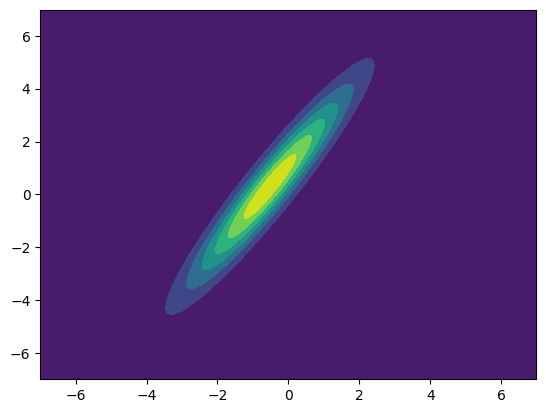

In [5]:
x, y = np.mgrid[-7:7:.01, -7:7:.01]
pos = np.dstack((x, y))

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

ax2.contourf(x, y, rv.pdf(pos))

In [6]:
def sgld_sample_gaussian_with_covariance(num_samples, theta_init, mu, Sigma, eta_0, burn_in=100, thinning=10):
    """
    SGLD algorithm to sample from a multivariate Gaussian distribution N(mu, Sigma).
    
    Parameters:
    - num_samples: Total number of samples to collect after burn-in.
    - theta_init: Initial value for theta.
    - mu: Mean of the Gaussian distribution.
    - Sigma: Covariance matrix of the Gaussian distribution.
    - eta_0: Initial learning rate (step size).
    - burn_in: Number of initial samples to discard (burn-in period).
    - thinning: Save every 'thinning' sample to reduce correlation between samples.
    
    Returns:
    - samples: Collected samples from the target distribution.
    """
    
    # Initialize theta
    theta = theta_init
    dim = theta.shape[0]  # Dimensionality of theta
    samples = []
    
    # Precompute the inverse of the covariance matrix Sigma
    Sigma_inv = np.linalg.inv(Sigma)
    
    # Total iterations needed (including burn-in and thinning)
    total_iterations = burn_in + (num_samples * thinning)
    
    for t in range(1, total_iterations + 1):
        # Learning rate schedule (eta_t = eta_0 / t)
        #eta_t = eta_0 / t
        
        # Gradient of log p(theta) for multivariate Gaussian N(mu, Sigma)
        grad_log_p_theta = -np.dot(Sigma_inv, (theta - mu))
        
        # Noise term: Gaussian noise with variance proportional to eta_t
        noise = np.random.normal(0, np.sqrt(eta_0), size=dim)
        
        # SGLD update step
        theta = theta + (eta_0 / 2) * grad_log_p_theta + noise
        
        # After burn-in, save samples with thinning
        if t > burn_in and (t - burn_in) % thinning == 0:
            samples.append(theta.copy())
    
    return np.array(samples)

# Parameters for the multivariate Gaussian distribution N(mu, Sigma)
mu = means  # Mean vector (non-zero)
Sigma = covariance_matrix  # Covariance matrix
eta_0 = 0.1  # Initial learning rate
theta_init = np.random.randn(2)  # Start with a 2D random point
num_samples = 5000  # Number of samples we want to collect after burn-in

# Run SGLD to sample from N(mu, Sigma)
samples = sgld_sample_gaussian_with_covariance(num_samples=num_samples, 
                                               theta_init=theta_init, 
                                               mu=mu, 
                                               Sigma=Sigma, 
                                               eta_0=eta_0,
                                               burn_in=100)

# Now samples contains the SGLD samples from N(mu, Sigma)
print("Mean of samples:", np.mean(samples, axis=0))
print("Covariance of samples:", np.cov(samples, rowvar=False))


Mean of samples: [-0.68053007  0.0350548 ]
Covariance of samples: [[2.18366928 3.38676007]
 [3.38676007 5.9957415 ]]


In [7]:
rv_sampled = multivariate_normal(np.mean(samples, axis=0), np.cov(samples, rowvar=False))

In [8]:
samples

array([[2.55460698, 5.09936365],
       [2.35217554, 4.61515335],
       [2.26859808, 6.42200201],
       ...,
       [0.43213345, 3.18116905],
       [2.03990368, 3.33930785],
       [0.4378209 , 2.77652672]])

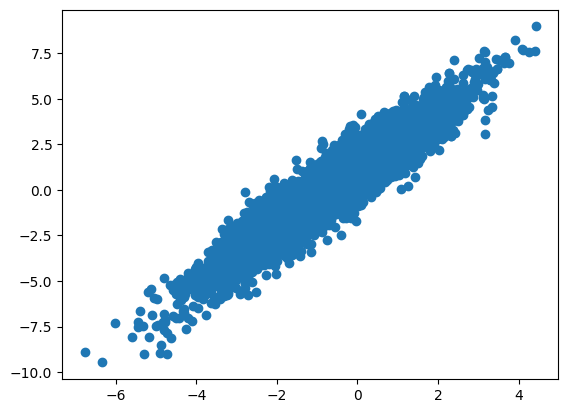

In [9]:
plt.scatter(samples[:, 0], samples[:, 1])

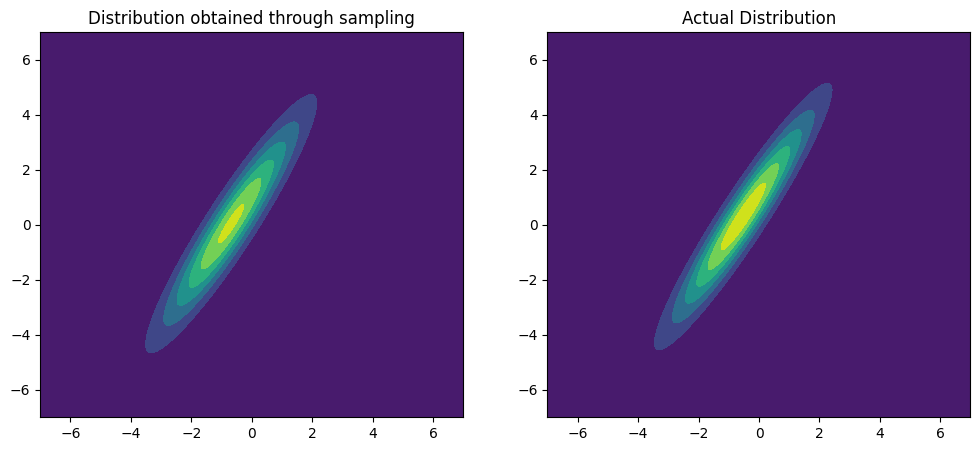

In [10]:
x, y = np.mgrid[-7:7:.01, -7:7:.01]
pos = np.dstack((x, y))

fig, (ax1, ax2) = plt.subplots(figsize=(12, 5), ncols=2)

ax1.contourf(x, y, rv_sampled.pdf(pos))
ax1.set_title("Distribution obtained through sampling")
ax2.contourf(x, y, rv.pdf(pos))
ax2.set_title("Actual Distribution")

plt.show()

In [24]:
def sgnht_sample_gaussian_with_covariance(num_samples, theta_init, r_init, eps_init, a, mu, Sigma, eta_0, burn_in=100, thinning=10):
    """
    SGNHT Implementation
    
    Parameters:
    - num_samples: Total number of samples to collect after burn-in.
    - theta_init: Initial value for theta.
    - mu: Mean of the Gaussian distribution.
    - Sigma: Covariance matrix of the Gaussian distribution.
    - eta_0: Initial learning rate (step size).
    - burn_in: Number of initial samples to discard (burn-in period).
    - thinning: Save every 'thinning' sample to reduce correlation between samples.
    
    Returns:
    - samples: Collected samples from the target distribution.
    """
    
    # Initialize theta
    theta = theta_init
    r = r_init
    eps = eps_init
    dim = theta.shape[0]  # Dimensionality of theta 
    samples = []
    
    # Precompute the inverse of the covariance matrix Sigma
    Sigma_inv = np.linalg.inv(Sigma)
    
    # Total iterations needed (including burn-in and thinning)
    total_iterations = burn_in + (num_samples * thinning)
    
    for t in range(1, total_iterations + 1):
        # Learning rate schedule (eta_t = eta_0 / t)
        if t % 10 == 0:
            r = np.random.normal(0, 1, size=(2,))
        eta_t = eta_0 
        
        # Gradient of log p(theta) for multivariate Gaussian N(mu, Sigma)
        grad_log_p_theta = np.dot(Sigma_inv, (theta - mu))
        
        # Noise term: Gaussian noise with variance proportional to eta_t
        noise = np.random.normal(0, eta_t * 2 * a, size=dim)
        
        # SGLD update step
        theta = theta + (eta_t) * r
        #print(r, (eta_t) * grad_log_p_theta, eta_t * r * eps, noise, (r.T @ r)/dim, (r.T @ r)/dim - 1)
        r = r - (eta_t) * grad_log_p_theta - eta_t * r * eps + noise
        #r = np.clip(r, -5, 5)
        eps = eps + eta_t * ((r.T @ r)/dim - 1)
        #eps = np.clip(eps, -5, 5)
        
        # After burn-in, save samples with thinning
        if t > burn_in and (t - burn_in) % thinning == 0:
            samples.append(theta.copy())
            #print(theta)
            
    
    return np.array(samples)

In [25]:
# Parameters for the multivariate Gaussian distribution N(mu, Sigma)
mu = means  # Mean vector (non-zero)
Sigma = covariance_matrix  # Covariance matrix
eta_0 = 0.1  # Initial learning rate
theta_init = np.random.randn(2)  # Start with a 2D random point
r_init = np.random.randn(2)
eps_init = 0
a = 1
num_samples = 10000  # Number of samples we want to collect after burn-in

# Run SGLD to sample from N(mu, Sigma)
samples = sgnht_sample_gaussian_with_covariance(num_samples=num_samples, 
                                               theta_init=theta_init,
                                               r_init = r_init,
                                               eps_init = eps_init,
                                               a = a,
                                               mu=mu, 
                                               Sigma=Sigma, 
                                               eta_0=eta_0,
                                               burn_in=100)

# Now samples contains the SGLD samples from N(mu, Sigma)
print("Mean of samples:", np.mean(samples, axis=0))
print("Covariance of samples:", np.cov(samples, rowvar=False))

Mean of samples: [-0.48500941  0.35659829]
Covariance of samples: [[1.96466048 2.94981738]
 [2.94981738 5.19895025]]


In [26]:
rv_sampled = multivariate_normal(np.mean(samples, axis=0), np.cov(samples, rowvar=False))

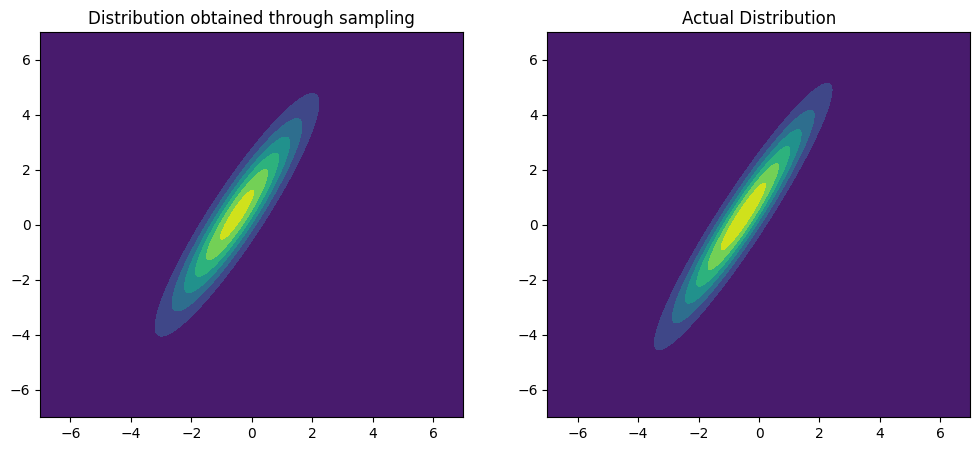

In [27]:
x, y = np.mgrid[-7:7:.01, -7:7:.01]
pos = np.dstack((x, y))

fig, (ax1, ax2) = plt.subplots(figsize=(12, 5), ncols=2)

ax1.contourf(x, y, rv_sampled.pdf(pos))
ax1.set_title("Distribution obtained through sampling")
ax2.contourf(x, y, rv.pdf(pos))
ax2.set_title("Actual Distribution")

plt.show()

In [28]:
def kl_divergence(samples, mu_P, Sigma_P):
    """
    Compute the KL divergence between a true Gaussian distribution P and an empirical distribution Q using samples.
    
    Parameters:
    - samples: Samples from the empirical distribution Q.
    - mu_P: Mean of the true Gaussian distribution P.
    - Sigma_P: Covariance matrix of the true Gaussian distribution P.
    
    Returns:
    - KL divergence estimate.
    """
    # Number of samples
    N = samples.shape[0]
    
    # Dimensionality of the problem
    d = samples.shape[1]
    
    # True distribution P (Gaussian)
    P = multivariate_normal(mean=mu_P, cov=Sigma_P)
    
    # Fit KDE to the samples to estimate Q
    kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(samples)
    
    # Compute the KL divergence using Monte Carlo approximation
    kl_div = 0.0
    
    for sample in samples:
        # Log probabilities for the true distribution P
        log_p_theta = P.logpdf(sample)
        
        # Log probabilities for the empirical distribution Q (estimated via KDE)
        log_q_theta = kde.score_samples(sample.reshape(1, -1))  # Log of Q(theta)
        #print(log_p_theta - log_q_theta)
        
        # Add to the KL divergence sum
        kl_div += (log_p_theta - log_q_theta)
    
    # Average the KL divergence over all samples
    kl_div /= N
    
    return kl_div

In [29]:
kl_divergence(samples, means, covariance_matrix)

array([0.42728744])

In [42]:
def sgrnht_sample_gaussian_with_covariance(num_samples, theta_init, r_init, eps_init, a, c, d, mu, Sigma, eta_0, burn_in=100, thinning=10):
    """
    SGNHT with added information about riemann information
    
    Parameters:
    - num_samples: Total number of samples to collect after burn-in.
    - theta_init: Initial value for theta.
    - mu: Mean of the Gaussian distribution.
    - Sigma: Covariance matrix of the Gaussian distribution.
    - eta_0: Initial learning rate (step size).
    - burn_in: Number of initial samples to discard (burn-in period).
    - thinning: Save every 'thinning' sample to reduce correlation between samples.
    
    Returns:
    - samples: Collected samples from the target distribution.
    """
    
    # Initialize theta
    theta = theta_init
    r = r_init
    eps = eps_init
    dim = theta.shape[0]  # Dimensionality of theta 
    samples = []
    
    # Precompute the inverse of the covariance matrix Sigma
    Sigma_inv = np.linalg.inv(Sigma)
    
    # Total iterations needed (including burn-in and thinning)
    total_iterations = burn_in + (num_samples * thinning)
    
    for t in range(1, total_iterations + 1):
        # Learning rate schedule (eta_t = eta_0 / t)
        if t % 10 == 0:
            r = np.random.normal(0, 1, size=(2,))
        eta_t = eta_0 
        
        # Calculate U(theta) and gradient of U(theta)
        grad_log_p_theta = np.dot(Sigma_inv, (theta - mu))
        log_p_theta = (theta - mu).T @ Sigma_inv @ (theta - mu)
        
        # Noise term: Gaussian noise with variance proportional to eta_t
        noise = np.random.normal(0, eta_t * 2 * a, size=dim)

        # Calculation of terms related to G
        G_inverse = d * np.sqrt(np.abs(log_p_theta + c))
        G_inverse_root = np.sqrt(G_inverse)
        correction_term = (np.sqrt(d) / 4) * np.power(log_p_theta + c, -3/4) * grad_log_p_theta
        
        # SGLD update step
        theta = theta + (eta_t) * G_inverse_root * r
        r = r - (eta_t) * G_inverse_root * grad_log_p_theta - eta_t * G_inverse * r * eps + correction_term + noise
        #r = np.clip(r, -5, 5)
        eps = eps + eta_t * ((r.T @ r) - 1)/dim
        #eps = np.clip(eps, -5, 5)
        
        # After burn-in, save samples with thinning
        if t > burn_in and (t - burn_in) % thinning == 0:
            samples.append(theta.copy())
            #print(theta)
            
    
    return np.array(samples)

In [43]:
# Parameters for the multivariate Gaussian distribution N(mu, Sigma)
mu = means  # Mean vector (non-zero)
Sigma = covariance_matrix  # Covariance matrix
eta_0 = 0.1  # Initial learning rate
theta_init = np.random.randn(2)  # Start with a 2D random point
r_init = np.random.randn(2)
eps_init = 0
a = 1
c = 0.5
d = 1.5
num_samples = 5000  # Number of samples we want to collect after burn-in

# Run SGLD to sample from N(mu, Sigma)
samples = sgrnht_sample_gaussian_with_covariance(num_samples=num_samples, 
                                               theta_init=theta_init,
                                               r_init = r_init,
                                               eps_init = eps_init,
                                               a = a,
                                               c = c,
                                               d = d,
                                               mu=mu, 
                                               Sigma=Sigma, 
                                               eta_0=eta_0,
                                               burn_in=100)

print("Mean of samples:", np.mean(samples, axis=0))
print("Covariance of samples:", np.cov(samples, rowvar=False))

Mean of samples: [-0.64377154  0.10077493]
Covariance of samples: [[2.81367761 4.35491938]
 [4.35491938 7.66010357]]


In [44]:
rv_sampled = multivariate_normal(np.mean(samples, axis=0), np.cov(samples, rowvar=False))

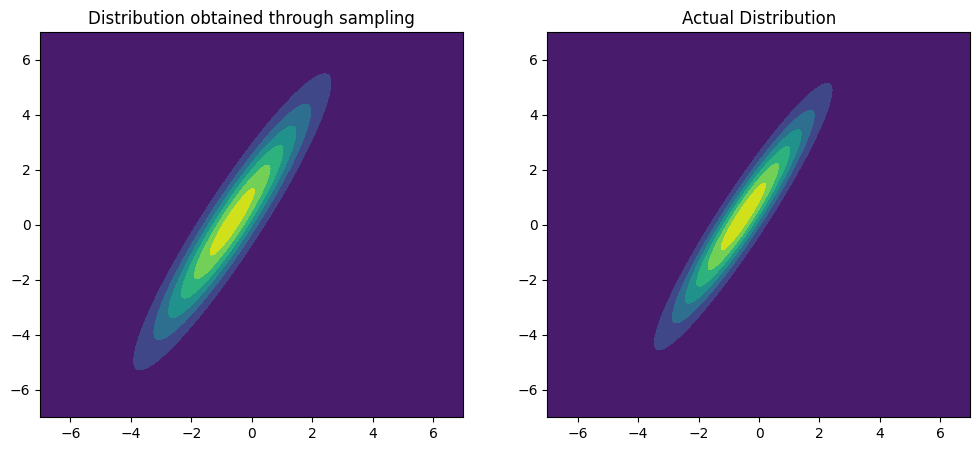

In [45]:
x, y = np.mgrid[-7:7:.01, -7:7:.01]
pos = np.dstack((x, y))

fig, (ax1, ax2) = plt.subplots(figsize=(12, 5), ncols=2)

ax1.contourf(x, y, rv_sampled.pdf(pos))
ax1.set_title("Distribution obtained through sampling")
ax2.contourf(x, y, rv.pdf(pos))
ax2.set_title("Actual Distribution")

plt.show()

In [46]:
kl_divergence(samples, means, covariance_matrix)

array([0.32043284])